このnotebookでは、stock_price_processed.csvを主に使ってEDA以降の操作を行う。

まず、データの基本統計量の確認、終値（endprice）と始値（startprice）の時系列プロットの作成、ヒストグラムと箱ひげ図を用いた、終値およびCR（変化率）の分布の可視化、自己相関プロットと偏自己相関プロット、30日移動平均のプロットを行った。

【Data Information】
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9202 entries, 1987-02-12 to 2024-08-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9202 non-null   int64  
 1   endprice    9202 non-null   float64
 2   startprice  9202 non-null   float64
 3   maxprice    9202 non-null   float64
 4   minprice    9202 non-null   float64
 5   trade       9202 non-null   float64
 6   CR          9202 non-null   float64
 7   CRabs       9202 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 647.0 KB
None

【Basic Statistics】
        Unnamed: 0     endprice   startprice     maxprice     minprice  \
count  9202.000000  9202.000000  9202.000000  9202.000000  9202.000000   
mean   4600.500000    92.180961    92.256183    93.176451    91.330146   
std    2656.532922    50.452228    50.598215    51.049837    50.087405   
min       0.000000    33.000000    33.000000    33.200000    32.200000   


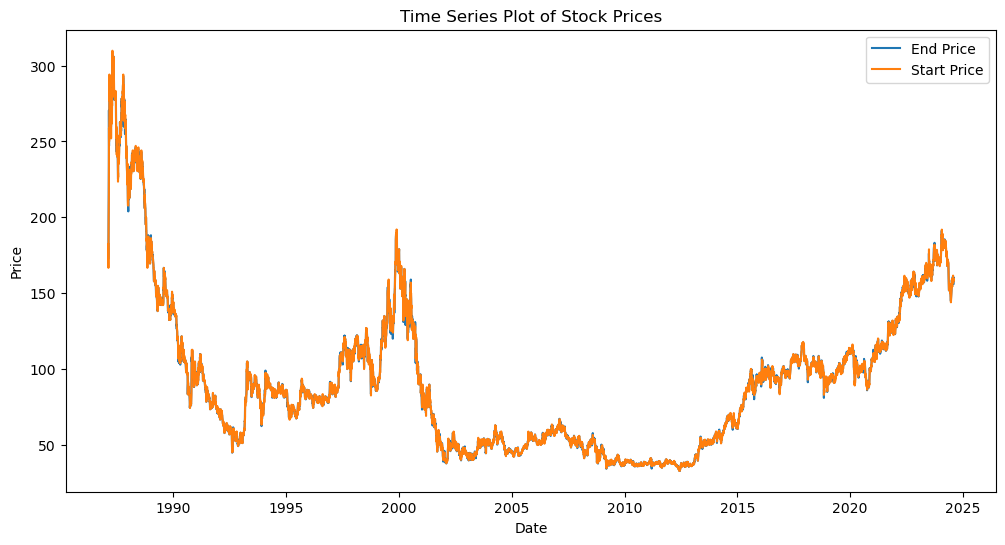

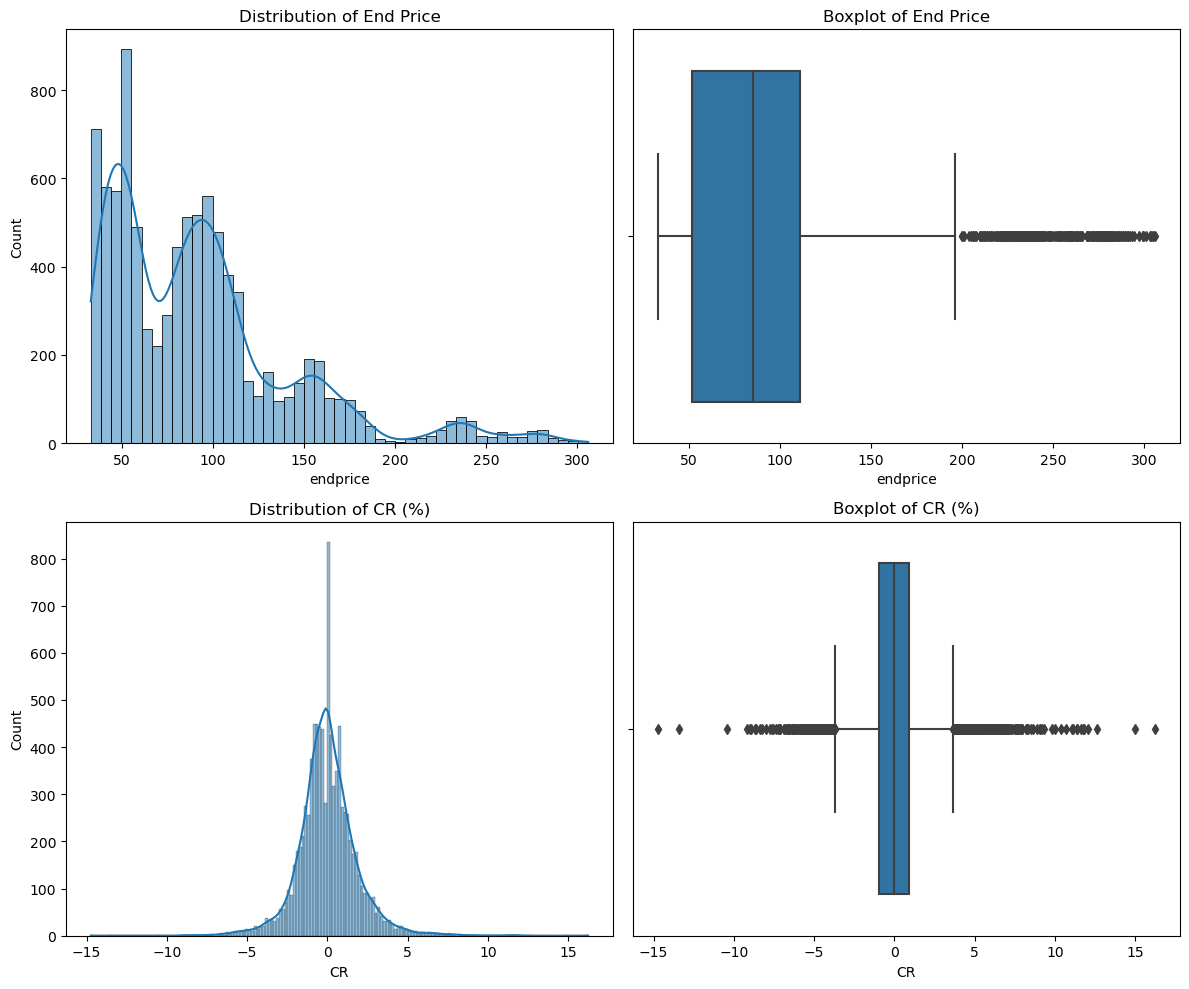

<Figure size 1200x600 with 0 Axes>

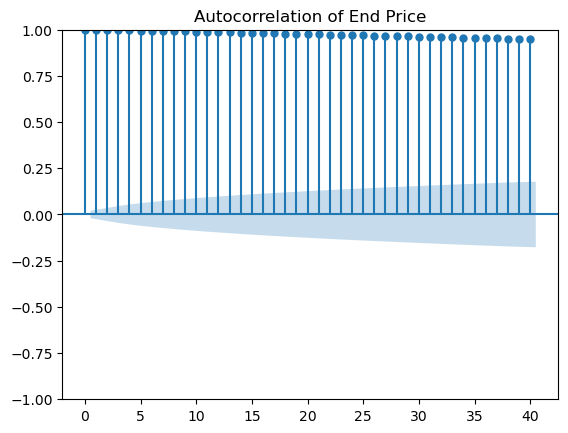

<Figure size 1200x600 with 0 Axes>

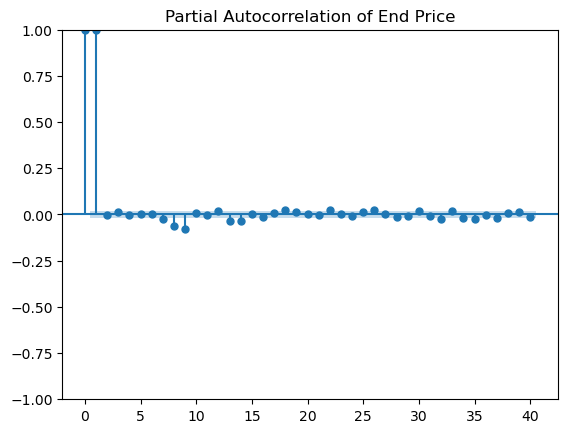

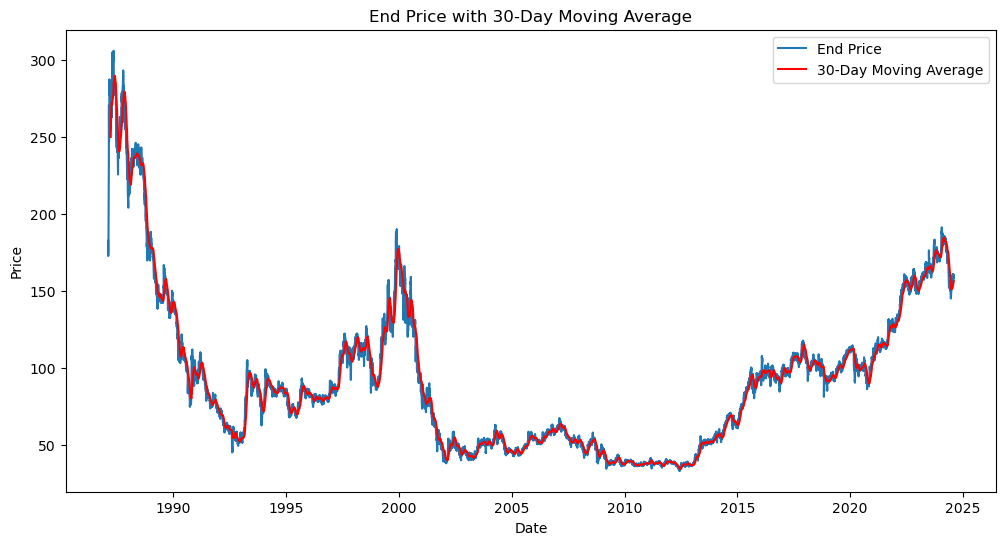

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# データの読み込み（ファイル名は適宜変更してください）
# 'date'列を日付型に変換し、ソート・インデックス設定
df = pd.read_csv('stock_price_processed.csv', parse_dates=['date'])
dfori = df.copy()
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# --- 基本統計量の確認 ---
print("【Data Information】")
print(df.info())
print("\n【Basic Statistics】")
print(df.describe())

# --- 欠損値のチェック ---
print("\n【Missing Values Check】")
print(df.isnull().sum())

# --- 時系列プロット ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['endprice'], label='End Price')
plt.plot(df.index, df['startprice'], label='Start Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series Plot of Stock Prices')
plt.legend()
plt.show()

# --- 分布の確認（ヒストグラムと箱ひげ図） ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['endprice'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of End Price')

sns.boxplot(x=df['endprice'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of End Price')

sns.histplot(df['CR'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of CR (%)')

sns.boxplot(x=df['CR'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of CR (%)')
plt.tight_layout()
plt.show()

# --- 自己相関・偏自己相関のプロット ---
plt.figure(figsize=(12, 6))
plot_acf(df['endprice'].dropna(), lags=40)
plt.title('Autocorrelation of End Price')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['endprice'].dropna(), lags=40)
plt.title('Partial Autocorrelation of End Price')
plt.show()

# --- 移動平均によるトレンドの可視化 ---
# 例として30日移動平均を計算
df['endprice_30d_MA'] = df['endprice'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['endprice'], label='End Price')
plt.plot(df.index, df['endprice_30d_MA'], label='30-Day Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('End Price with 30-Day Moving Average')
plt.legend()
plt.show()

前処理、特徴量エンジニアリング、学習用データの作成および整形を行った。そこからLSTMモデルの構築と学習、さらに予測結果のプロット、学習データとテストデータにおける損失関数のプロットによる過学習の監視、また、予測結果の評価を行った。

まず、特徴量エンジニアリングでは、
・lag特徴量（直前3日分のendprice）

・移動平均（5日、10日）

・ボラティリティ：CRの5日間の標準偏差（CRは%変化率）

・曜日情報（0:月～4:金）

を追加した。

学習用データの作成および整形では、スライディングウィンドウ法を用いて、過去20営業日分の各特徴量（lag特徴量、移動平均、ボラティリティ、曜日情報）から入力シーケンスXを作成し、翌日のendpriceをターゲットyとして抽出した。さらに、データを80%の学習用と20%のテスト用に分割し、Xは各タイムステップごとにMinMaxScalerで正規化、yも同様にスケーリングを施して整形した。


その後、2層のLSTM（各層50ユニット）とDropout層を組み合わせ、Dense層で翌日の株価を予測するモデルを構築し、Adamオプティマイザと平均二乗誤差（MSE）損失関数を用いて、50エポック、バッチサイズ32で学習を行った。


さらに、テストデータに対してモデルの予測結果を取得し、実際の株価（翌日のendprice）と予測値をプロットして比較することで、予測の傾向を視覚的に確認した。


学習中は、トレーニングデータと検証データそれぞれの損失値（lossとval_loss）をエポックごとにプロットし、過学習の有無や学習の進行状況をモニタリングした。


最後に、MAE、MSE、RMSEなどの評価指標を用いて、モデルの予測精度を定量的に評価し、さらに実際の株価変化と予測結果をもとに、取引戦略上の損益評価も行った。
特に、前日の株価に対して当日の実際の株価が上がったか否かと、予測では株価が上がると予測したか否かのみに着目して株価の上昇・下降を適切に言い当てられているかを検証したり、株価の上昇or下降の予測についてどちらかのみに偏っている傾向がないか調べた。

また、株価の上昇下降の説明力は低くても株価の変動が大きい時に株価の上昇下落を予測できれば株で利益を出すという目的は達成できるため、上がると予測すれば一定の株を買い、下がると予測すれば一定の株を売るという戦略を取った時のテスト期間全体の損益を計算した。

さらに、回帰問題として株価を予測しているのでそこの評価もしたい。そのため、前日の株価と比べた当日の株価の予測値の差が大きいほど売買する株の量を大きくするという戦略を取るような場合を考え、前日の株価と比べた当日の株価の予測値の差の絶対値（平均は1となるようにし、普通の損益と比較できるようにする）によって損益を重みづけした、テスト期間全体の重み付き損益も評価指標として出力した。

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 20, 50)            11800     
                                                                 
 dropout_70 (Dropout)        (None, 20, 50)            0         
                                                                 
 lstm_71 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_71 (Dropout)        (None, 50)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 32,051
Trainable params: 32,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
207/207 [=============================

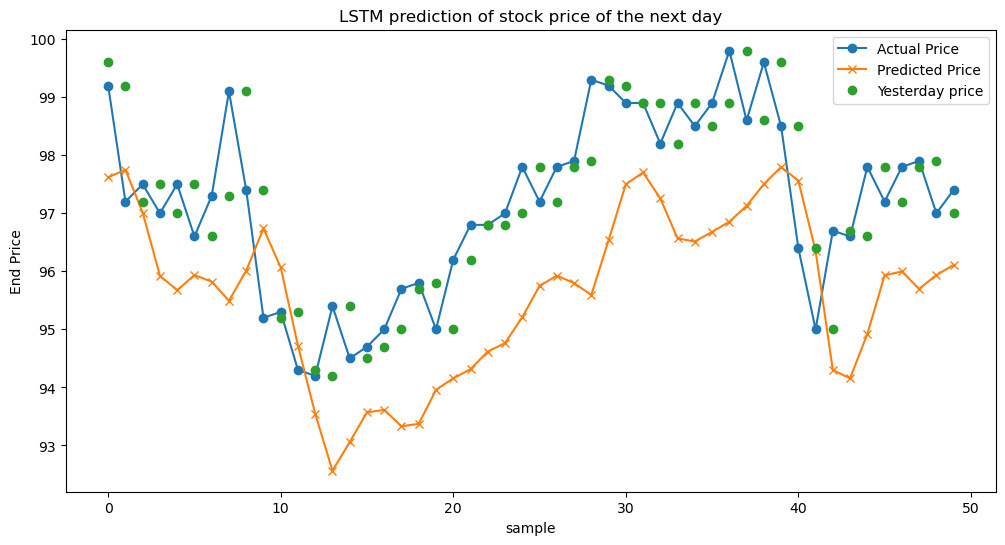

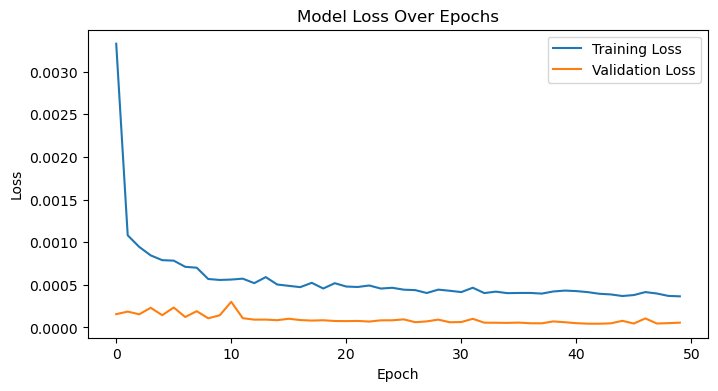

実際に上昇、予測も上昇: 35
実際に上昇、予測は下降: 863
実際に下降、予測も下降: 845
実際に下降、予測は上昇: 20
方向性正解率 (Directional Accuracy): 47.96%
テスト期間全体の損益 (PnL): -6.800000000000068
テスト期間全体の重み付き損益 (Weighted PnL): 13.15075212331213
1日あたりの平均重み付き損益: 0.007170530056331587


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 前処理・スケーリング・モデル構築に必要なライブラリ
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. データ読み込みと前処理
df = pd.read_csv('stock_price_processed.csv', parse_dates=['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# --- 特徴量エンジニアリング ---
# ・lag特徴量（直前3日分のendprice）
# ・移動平均（5日、10日）
# ・ボラティリティ：CRの5日間の標準偏差（CRは%変化率）
# ・曜日情報（0:月～4:金）
df['lag1_endprice'] = df['endprice'].shift(1)
df['lag2_endprice'] = df['endprice'].shift(2)
df['lag3_endprice'] = df['endprice'].shift(3)

df['MA5_endprice'] = df['endprice'].rolling(window=5).mean()
df['MA10_endprice'] = df['endprice'].rolling(window=10).mean()

df['volatility_5d'] = df['CR'].rolling(window=5).std()

# 曜日情報（平日のみなので0～4の値）を特徴量として追加
df['weekday'] = df.index.weekday

# ここではendpriceと上記特徴量のみを使用
features = ['endprice', 'lag1_endprice', 'lag2_endprice', 'lag3_endprice',
            'MA5_endprice', 'MA10_endprice', 'volatility_5d', 'weekday']

df_features = df[features].dropna()  # シフトやrollingによりNaNが発生するため削除

# 2. 学習用データの作成（スライディングウィンドウ）
# 次の日のendpriceを予測するので、入力シーケンスの長さ（例：過去20営業日）を決定
sequence_length = 20

# 入力シーケンス X と予測対象 y のリストを作成
X, y = [], []
for i in range(sequence_length, len(df_features)):
    X.append(df_features.iloc[i-sequence_length:i].values)
    # 予測対象はi番目のendprice（翌日）
    y.append(df_features.iloc[i]['endprice'])
    
X = np.array(X)
y = np.array(y)

# 3. 学習・検証用データの分割（80% train / 20% test）
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. 特徴量のスケーリング
# 時系列データは各タイムステップごとにスケーリングするため、まず2次元に変形
n_train_samples, seq_len, n_features = X_train.shape
X_train_2d = X_train.reshape(-1, n_features)
X_test_2d  = X_test.reshape(-1, n_features)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled  = scaler.transform(X_test_2d)

# 元の形状に戻す
X_train_scaled = X_train_scaled.reshape(n_train_samples, seq_len, n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], seq_len, n_features)

# また、ターゲット変数（endprice）は値のスケーリングも行うと学習が安定する
price_scaler = MinMaxScaler()
y_train_scaled = price_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = price_scaler.transform(y_test.reshape(-1, 1))

# 5. LSTMモデルの構築
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # 次の日のendpriceを予測

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# 6. モデルの学習
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)

# 7. 予測と評価
y_pred_scaled = model.predict(X_test_scaled)
y_pred = price_scaler.inverse_transform(y_pred_scaled)

# 評価指標
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)

# 8. 予測結果のプロット（テスト期間の2番目からの50サンプルを表示）
plt.figure(figsize=(12,6))
plt.plot(y_test[1:51], label='Actual Price', marker='o')
plt.plot(y_pred[1:51], label='Predicted Price', marker='x')
plt.plot(y_test[0:50], linestyle='', label='Yesterday price', marker='o')
plt.title("LSTM prediction of stock price of the next day")
plt.xlabel("sample")
plt.ylabel("End Price")
plt.legend()
plt.show()

#lossの評価
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#儲けられるかの評価

import numpy as np

# 学習データの最後の株価を前日株価として利用
last_train_price = y_train[-1, 0] if y_train.ndim > 1 else y_train[-1]
test_price = y_test.flatten()   # 実際の株価（テスト期間）
y_pred = y_pred.flatten()         # 予測株価

# 前日株価の配列を作成
prev_prices = np.empty_like(test_price)
prev_prices[0] = last_train_price
prev_prices[1:] = test_price[:-1]

# 実際の変化量と予測変化量を計算
actual_changes = test_price - prev_prices          # 実際の株価変化
predicted_changes = y_pred - prev_prices            # 予測された株価変化

# 重みの正規化: 各日の重みは abs(predicted_changes) とするが、
# テスト期間全体での平均が1になるように調整する
raw_weights = np.abs(predicted_changes)
normalization_factor = np.mean(raw_weights)
normalized_weights = raw_weights / normalization_factor

# 4通りのケースごとのカウントと、重みなし損益・重み付き損益を計算する変数を初期化
up_up_losses = []      # 実際に上昇、予測も上昇の場合の絶対変化
up_down_losses = []    # 実際に上昇、予測は下降の場合
down_down_losses = []  # 実際に下降、予測も下降の場合
down_up_losses = []    # 実際に下降、予測は上昇の場合

pnl = 0             # 通常の損益
weighted_pnl = 0    # 重み付き損益

# 各サンプルごとの処理
for i, (act, pred, weight) in enumerate(zip(actual_changes, predicted_changes, normalized_weights)):
    base_error = abs(act)  # 当日の株価変化の絶対値
    # 方向性による処理
    if act > 0:
        if pred > 0:
            up_up_losses.append(base_error)
            pnl += base_error
            weighted_pnl += base_error * weight
        else:
            up_down_losses.append(base_error)
            pnl -= base_error
            weighted_pnl -= base_error * weight
    elif act < 0:
        if pred < 0:
            down_down_losses.append(base_error)
            pnl += base_error
            weighted_pnl += base_error * weight
        else:
            down_up_losses.append(base_error)
            pnl -= base_error
            weighted_pnl -= base_error * weight
    # act==0 の場合は変化なし

# 各ケースのカウント
up_up = len(up_up_losses)
up_down = len(up_down_losses)
down_down = len(down_down_losses)
down_up = len(down_up_losses)

correct = up_up + down_down
total = len(test_price)
directional_accuracy = correct / total

print("実際に上昇、予測も上昇:", up_up)
print("実際に上昇、予測は下降:", up_down)
print("実際に下降、予測も下降:", down_down)
print("実際に下降、予測は上昇:", down_up)
print("方向性正解率 (Directional Accuracy): {:.2%}".format(directional_accuracy))

print("テスト期間全体の損益 (PnL):", pnl)
print("テスト期間全体の重み付き損益 (Weighted PnL):", weighted_pnl)

avg_daily_weighted_pnl = weighted_pnl / (total - 1)
print("1日あたりの平均重み付き損益:", avg_daily_weighted_pnl)

結果を見ると、下降すると予測するように偏っており、方向性正解率も50%を下回っている。また、損益もともに非常に小さい。
何回かこのモデルを学習させたが、上昇か下降のどちらかに予測が偏ることが多く、方向性正解率は50%を下回ることが多かった。損益については、正になることの方が負になることよりもやや多い印象を受けた。重み付き損益の方が普通の損益よりも高くなることがほとんどであった。

いずれにせよ、上昇か下降のどちらかに予測が偏ることが多いため、これを改善することで予測性能がよくなるという仮説を立て、損失関数に上昇と下降を予測できたかの項を追加し、ここが間違っていた場合ペナルティを与えて学習させた。

c:\Users\mintk\anaconda3\envs\anaconda3_base_tensorflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 20, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,102 (125.40 KB)

 Trainable params: 32,102 (125.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 811.8973 - val_loss: 411.8019
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 683.4641 - val_loss: 301.8906
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 571.7690 - val_loss: 218.5154
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 482.3612 - val_loss: 155.5739
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 395.5750 - val_loss: 109.4994
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 357.3014 - val_loss: 77.0619
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 338.6422 - val_loss: 54.9057
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 319.5654 - val_loss: 40.6947
Epoch 9/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 298.6963 - val_loss: 32.1888
Epoch 10/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 294.5991 - val_loss: 27.3420
Epoch 11/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 288.0366 - val_loss: 24.9201
Epoch 12/50
20

C:\Users\mintk\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mintk\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12424 (\N{HIRAGANA LETTER YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mintk\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mintk\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mintk\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOG

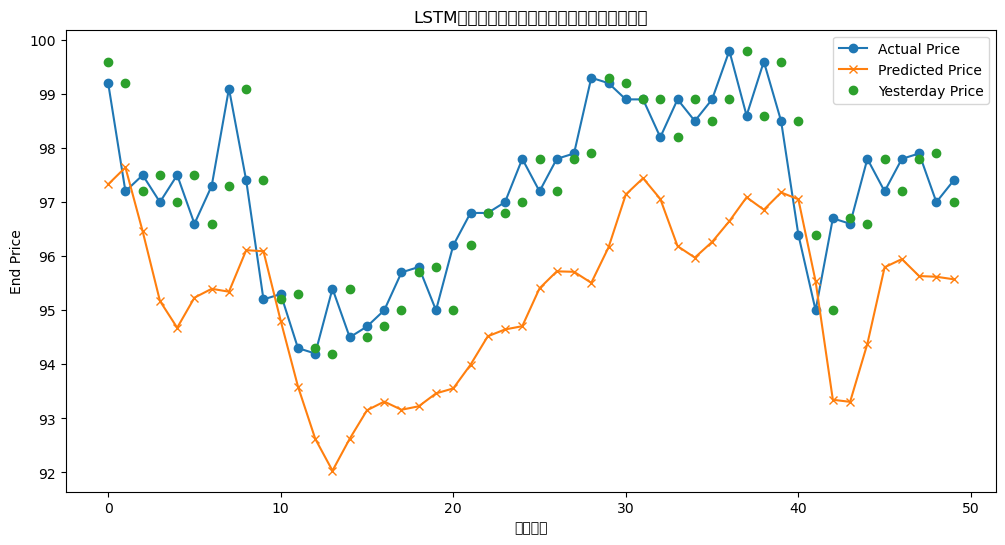

実際に上昇、予測も上昇: 7
実際に上昇、予測は下降: 891
実際に下降、予測も下降: 861
実際に下降、予測は上昇: 4
方向性正解率 (Directional Accuracy): 47.30%
テスト期間全体の損益 (PnL): -46.80000000000004
テスト期間全体の重み付き損益 (Weighted PnL): -48.92197860524389
1日あたりの平均重み付き損益: -0.0266750155971886


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 前処理・スケーリング・モデル構築に必要なライブラリ
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
import tensorflow as tf

# 1. データ読み込みと前処理
df = pd.read_csv('stock_price_processed.csv', parse_dates=['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# --- 特徴量エンジニアリング ---
df['lag1_endprice'] = df['endprice'].shift(1)
df['lag2_endprice'] = df['endprice'].shift(2)
df['lag3_endprice'] = df['endprice'].shift(3)

df['MA5_endprice'] = df['endprice'].rolling(window=5).mean()
df['MA10_endprice'] = df['endprice'].rolling(window=10).mean()

df['volatility_5d'] = df['CR'].rolling(window=5).std()
df['weekday'] = df.index.weekday

features = ['endprice', 'lag1_endprice', 'lag2_endprice', 'lag3_endprice',
            'MA5_endprice', 'MA10_endprice', 'volatility_5d', 'weekday']
df_features = df[features].dropna()

# 2. 学習用データの作成（スライディングウィンドウ）
# 例：過去20営業日分を入力として、翌日のendpriceを予測
sequence_length = 20
X, y = [], []
for i in range(sequence_length, len(df_features)):
    window = df_features.iloc[i-sequence_length:i].values  # shape: (sequence_length, n_features)
    X.append(window)
    next_day_price = df_features.iloc[i]['endprice']         # 翌日のendprice
    prev_day_price = window[-1, 0]                             # 入力シーケンス最後のendprice＝前日の株価
    y.append([next_day_price, prev_day_price])
    
X = np.array(X)
y = np.array(y)

# 3. 学習・検証用データの分割（80% train / 20% test）
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. 特徴量のスケーリング
n_train_samples, seq_len, n_features = X_train.shape
X_train_2d = X_train.reshape(-1, n_features)
X_test_2d  = X_test.reshape(-1, n_features)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled  = scaler.transform(X_test_2d)

X_train_scaled = X_train_scaled.reshape(n_train_samples, seq_len, n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], seq_len, n_features)

# ターゲット変数のうち翌日株価部分（1列目）をスケーリング
price_scaler = MinMaxScaler()
y_train_price_scaled = price_scaler.fit_transform(y_train[:,0].reshape(-1,1))
y_test_price_scaled = price_scaler.transform(y_test[:,0].reshape(-1,1))
# 2列目（前日の株価）はそのまま残す（または別途スケーリングするが、ここでは元のスケールを使用）
y_train_scaled = np.hstack([y_train_price_scaled, y_train[:,1].reshape(-1,1)])
y_test_scaled = np.hstack([y_test_price_scaled, y_test[:,1].reshape(-1,1)])

# 5. カスタム損失関数の定義
def custom_loss(y_true, y_pred):
    # y_true[:,0] : 実際の翌日株価, y_true[:,1] : 前日の株価（既知）
    # y_pred[:,0] : 予測された翌日株価, y_pred[:,1] : 予測された前日の株価（本来は y_true[:,1] に一致させたい）
    mse_loss = K.mean(K.square(y_true[:,0] - y_pred[:,0]))
    
    # 実際の変化と予測変化（前日の株価との差）
    actual_change = y_true[:,0] - y_true[:,1]
    pred_change = y_pred[:,0] - y_true[:,1]  # ここは ground truth の前日株価を使用
    
    # 符号の一致をチェック
    actual_direction = K.sign(actual_change)
    pred_direction = K.sign(pred_change)
    # 方向不一致のマスク（不一致なら1.0）
    direction_mismatch = K.cast(K.not_equal(actual_direction, pred_direction), K.floatx())
    
    penalty = K.mean(direction_mismatch * K.abs(actual_change))
    lambda_param = 1.0
    
    # 補助損失：2列目の出力が正しくコピーされるようにする（小さな係数をかける）
    copy_loss = K.mean(K.square(y_true[:,1] - y_pred[:,1]))
    return mse_loss + lambda_param * penalty + 0.1 * copy_loss

# 6. LSTMモデルの構築
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
# 出力層は2ユニット：1つ目が翌日の株価予測、2つ目は前日の株価のコピー用
model.add(Dense(2))

model.compile(optimizer='adam', loss=custom_loss)
model.summary()

# 7. モデルの学習
# ターゲットはy_train_scaled（形状：(num_samples, 2)）
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32,
                    validation_split=0.1, verbose=1)

# 8. 予測と評価
y_pred_scaled = model.predict(X_test_scaled)  # shape: (num_samples, 2)
# 予測の1列目が翌日の株価予測
y_pred_price = price_scaler.inverse_transform(y_pred_scaled[:,0].reshape(-1,1))

mae = mean_absolute_error(y_test[:,0], y_pred_price)
mse_val = mean_squared_error(y_test[:,0], y_pred_price)
rmse = np.sqrt(mse_val)
print("Test MAE:", mae)
print("Test MSE:", mse_val)
print("Test RMSE:", rmse)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 予測と評価 ---
# 予測: model.predict(X_test_scaled) は shape (num_samples, 2) の出力を返す
y_pred_scaled = model.predict(X_test_scaled)
# 予測の1列目が翌日の株価予測。逆スケーリングして元のスケールに戻す
y_pred_price = price_scaler.inverse_transform(y_pred_scaled[:,0].reshape(-1,1))
y_pred_price = y_pred_price.flatten()

# 実際の翌日の株価は y_test の1列目
actual_price = y_test[:,0].flatten()

# 評価指標（ここでは翌日の株価のみで計算）
mae = mean_absolute_error(actual_price, y_pred_price)
mse_val = mean_squared_error(actual_price, y_pred_price)
rmse = np.sqrt(mse_val)
print("Test MAE:", mae)
print("Test MSE:", mse_val)
print("Test RMSE:", rmse)

# --- 予測結果のプロット（テスト期間の最初の50サンプル） ---
plt.figure(figsize=(12,6))
plt.plot(actual_price[1:51], label='Actual Price', marker='o')
plt.plot(y_pred_price[1:51], label='Predicted Price', marker='x')
# 昨日分はテストデータの最初の50サンプルの前日株価
plt.plot(actual_price[0:50], linestyle='', label='Yesterday Price', marker='o')
plt.title("LSTM prediction of stock price of the next day")
plt.xlabel("sample")
plt.ylabel("End Price")
plt.legend()
plt.show()

# --- 損益評価（方向性評価と重み付き損益） ---

# 前提：
# - last_train_price: 学習データ（y_train）の最後の翌日株価（1列目）を、前日株価として利用
# - actual_price: テスト期間の実際の翌日株価（1列目）
# - y_pred_price: モデルの予測翌日株価（1列目）

# 学習データの最後の翌日株価（y_trainの1列目）を前日の株価として利用
last_train_price = y_train[-1, 0] if y_train.ndim > 1 else y_train[-1]

# 作成する前日株価配列：テスト期間最初の日は last_train_price、その後は実際のテストデータ内の前日の実際株価
prev_prices = np.empty_like(actual_price)
prev_prices[0] = last_train_price
prev_prices[1:] = actual_price[:-1]

# 各日の実際の変化量と予測の変化量（前日株価との差）を計算
actual_changes = actual_price - prev_prices           # 実際の変化
predicted_changes = y_pred_price - prev_prices         # 予測された変化

# 重みの正規化：各日の重みを abs(predicted_changes) とし、テスト期間全体での平均が1になるよう調整
raw_weights = np.abs(predicted_changes)
normalization_factor = np.mean(raw_weights)
normalized_weights = raw_weights / normalization_factor

# 4通りのケースごとにカウントおよび、重みなし・重み付き損益を計算
up_up_losses = []      # 実際に上昇、予測も上昇
up_down_losses = []    # 実際に上昇、予測は下降
down_down_losses = []  # 実際に下降、予測も下降
down_up_losses = []    # 実際に下降、予測は上昇

pnl = 0             # 通常の損益
weighted_pnl = 0    # 重み付き損益

# 各サンプルごとに処理
for i, (act, pred, weight) in enumerate(zip(actual_changes, predicted_changes, normalized_weights)):
    base_error = abs(act)  # 当日の実際の変化量の絶対値
    if act > 0:
        if pred > 0:
            up_up_losses.append(base_error)
            pnl += base_error
            weighted_pnl += base_error * weight
        else:
            up_down_losses.append(base_error)
            pnl -= base_error
            weighted_pnl -= base_error * weight
    elif act < 0:
        if pred < 0:
            down_down_losses.append(base_error)
            pnl += base_error
            weighted_pnl += base_error * weight
        else:
            down_up_losses.append(base_error)
            pnl -= base_error
            weighted_pnl -= base_error * weight
    # act == 0 の場合は変化なしなので何もしない

# 各ケースのカウント
up_up = len(up_up_losses)
up_down = len(up_down_losses)
down_down = len(down_down_losses)
down_up = len(down_up_losses)

correct = up_up + down_down
total = len(actual_price)
directional_accuracy = correct / total

print("実際に上昇、予測も上昇:", up_up)
print("実際に上昇、予測は下降:", up_down)
print("実際に下降、予測も下降:", down_down)
print("実際に下降、予測は上昇:", down_up)
print("方向性正解率 (Directional Accuracy): {:.2%}".format(directional_accuracy))


print("テスト期間全体の損益 (PnL):", pnl)
print("テスト期間全体の重み付き損益 (Weighted PnL):", weighted_pnl)
avg_daily_weighted_pnl = weighted_pnl / (total - 1)
print("1日あたりの平均重み付き損益:", avg_daily_weighted_pnl)


このモデルは、先ほどのモデルに比べ不安定になることが多く、また、予測成績も最初のモデルと比べて悪化していたため、不採用にした。

最初に構築したモデルについて、ハイパーパラメータを調整していなかったため、これを調節することで性能が良くなるという仮説を立てた。ハイパーパラメータは、optunaを使ってベイズ最適化によって最適なものを見つけることにした。ハイパーパラメータは、LSTMのユニット数、ドロップアウト率、学習率、バッチサイズを調整した。また、エポック数を少なくしたり成績の悪いものは途中で検証を中断することでハイパーパラメータの検証にかかる時間を短くした。


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 前処理・スケーリング・モデル構築に必要なライブラリ
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
import optuna
from optuna.integration import TFKerasPruningCallback

# --- 共通部分：前処理～ターゲットのスケーリング ---
df = pd.read_csv('stock_price_processed.csv', parse_dates=['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# 特徴量エンジニアリング
df['lag1_endprice'] = df['endprice'].shift(1)
df['lag2_endprice'] = df['endprice'].shift(2)
df['lag3_endprice'] = df['endprice'].shift(3)
df['MA5_endprice'] = df['endprice'].rolling(window=5).mean()
df['MA10_endprice'] = df['endprice'].rolling(window=10).mean()
df['volatility_5d'] = df['CR'].rolling(window=5).std()
df['weekday'] = df.index.weekday
features = ['endprice', 'lag1_endprice', 'lag2_endprice', 'lag3_endprice',
            'MA5_endprice', 'MA10_endprice', 'volatility_5d', 'weekday']
df_features = df[features].dropna()

# スライディングウィンドウによる学習用データの作成
sequence_length = 20
X, y = [], []
for i in range(sequence_length, len(df_features)):
    X.append(df_features.iloc[i-sequence_length:i].values)
    y.append(df_features.iloc[i]['endprice'])
X = np.array(X)
y = np.array(y)

# 学習・検証用データの分割（80% train / 20% test）
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 特徴量のスケーリング
n_train_samples, seq_len, n_features = X_train.shape
X_train_2d = X_train.reshape(-1, n_features)
X_test_2d  = X_test.reshape(-1, n_features)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled  = scaler.transform(X_test_2d)
X_train_scaled = X_train_scaled.reshape(n_train_samples, seq_len, n_features)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], seq_len, n_features)

# ターゲット変数（endprice）のスケーリング
price_scaler = MinMaxScaler()
y_train_scaled = price_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = price_scaler.transform(y_test.reshape(-1, 1))

# --- Optuna を用いたハイパーパラメータ探索 ---
def objective(trial):
    # ハイパーパラメータの候補を提案
    lstm_units = trial.suggest_int("lstm_units", 30, 100)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 64)
    
    # モデル構築
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(sequence_length, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # 翌日のendpriceを予測
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # EarlyStopping と Optuna のプルーニングコールバックを設定
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0),
        TFKerasPruningCallback(trial, 'val_loss')
    ]
    
    # エポック数を15に減らして学習時間を短縮
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=15,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0,
        callbacks=callbacks
    )
    
    # 最終エポックの検証損失を返す
    return history.history['val_loss'][-1]

# スタディの作成と探索実行（試行回数は30程度に設定）
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_trial.params)

# --- 最適なハイパーパラメータでモデルを再構築・学習 ---
best_params = study.best_trial.params
best_lstm_units = best_params["lstm_units"]
best_dropout_rate = best_params["dropout_rate"]
best_learning_rate = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]

model = Sequential()
model.add(LSTM(best_lstm_units, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(Dropout(best_dropout_rate))
model.add(LSTM(best_lstm_units))
model.add(Dropout(best_dropout_rate))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=best_batch_size,
    validation_split=0.1,
    verbose=1
)

# --- 予測と評価 ---
y_pred_scaled = model.predict(X_test_scaled)
y_pred = price_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse_val = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_val)
print("Test MAE:", mae)
print("Test MSE:", mse_val)
print("Test RMSE:", rmse)

[I 2025-02-24 15:30:27,479] A new study created in memory with name: no-name-43564881-082b-4e23-b59a-1a7f559727c5
[I 2025-02-24 15:31:00,096] Trial 0 finished with value: 0.00030837469967082143 and parameters: {'lstm_units': 69, 'dropout_rate': 0.20662186565606439, 'learning_rate': 0.004165204418948327, 'batch_size': 19}. Best is trial 0 with value: 0.00030837469967082143.
[I 2025-02-24 15:31:21,657] Trial 1 finished with value: 0.0001533414178993553 and parameters: {'lstm_units': 62, 'dropout_rate': 0.1031957911536158, 'learning_rate': 0.006060382595775066, 'batch_size': 30}. Best is trial 1 with value: 0.0001533414178993553.
[I 2025-02-24 15:31:34,404] Trial 2 finished with value: 0.0002343281521461904 and parameters: {'lstm_units': 49, 'dropout_rate': 0.47018608624430225, 'learning_rate': 0.005786411385262962, 'batch_size': 27}. Best is trial 1 with value: 0.0001533414178993553.
[I 2025-02-24 15:31:44,323] Trial 3 finished with value: 0.00017902565014082938 and parameters: {'lstm_un

Best hyperparameters: {'lstm_units': 61, 'dropout_rate': 0.14576491809377018, 'learning_rate': 0.0005317260751089603, 'batch_size': 58}
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 20, 61)            17080     
                                                                 
 dropout_68 (Dropout)        (None, 20, 61)            0         
                                                                 
 lstm_69 (LSTM)              (None, 61)                30012     
                                                                 
 dropout_69 (Dropout)        (None, 61)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 62        
                                                                 
Total params: 47,154
Trainable params: 47,154
Non

Best hyperparameters: {'lstm_units': 61, 'dropout_rate': 0.14576491809377018, 'learning_rate': 0.0005317260751089603, 'batch_size': 58}
となった。このモデルの性能を評価する。

c:\Users\mintk\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mintk\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12424 (\N{HIRAGANA LETTER YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mintk\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mintk\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mintk\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65

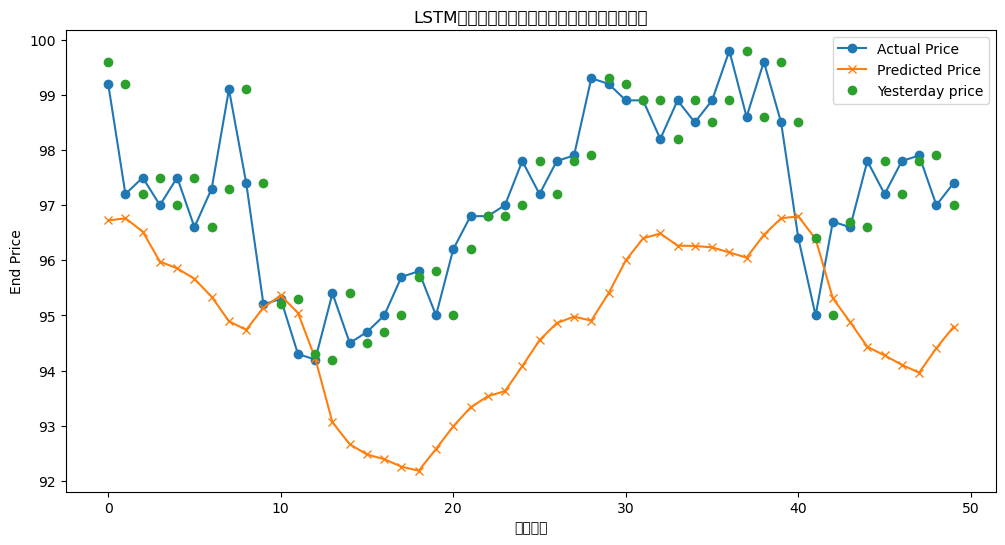

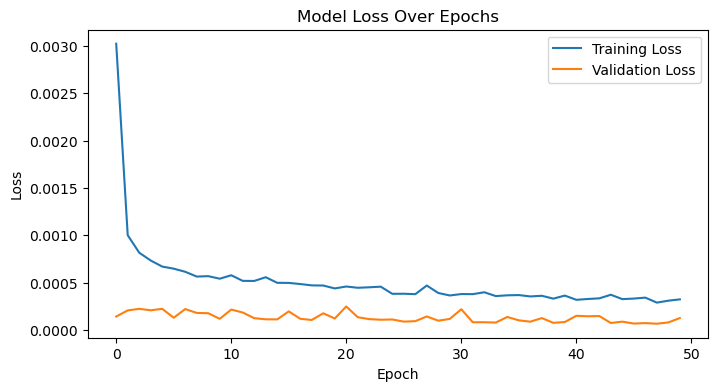

実際に上昇、予測も上昇: 42
実際に上昇、予測は下降: 856
実際に下降、予測も下降: 837
実際に下降、予測は上昇: 28
方向性正解率 (Directional Accuracy): 47.90%
テスト期間全体の損益 (PnL): -13.399999999999977
テスト期間全体の重み付き損益 (Weighted PnL): 32.26990983337995
1日あたりの平均重み付き損益: 0.017595370683413276


In [3]:
# 8. 予測結果のプロット（テスト期間の2番目からの50サンプルを表示）
plt.figure(figsize=(12,6))
plt.plot(y_test[1:51], label='Actual Price', marker='o')
plt.plot(y_pred[1:51], label='Predicted Price', marker='x')
plt.plot(y_test[0:50], linestyle='', label='Yesterday price', marker='o')
plt.title("LSTMによる次日株価予測（テストデータ一部）")
plt.xlabel("サンプル")
plt.ylabel("End Price")
plt.legend()
plt.show()

#lossの評価
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#儲けられるかの評価

import numpy as np

# 学習データの最後の株価を前日株価として利用
last_train_price = y_train[-1, 0] if y_train.ndim > 1 else y_train[-1]
test_price = y_test.flatten()   # 実際の株価（テスト期間）
y_pred = y_pred.flatten()         # 予測株価

# 前日株価の配列を作成
prev_prices = np.empty_like(test_price)
prev_prices[0] = last_train_price
prev_prices[1:] = test_price[:-1]

# 実際の変化量と予測変化量を計算
actual_changes = test_price - prev_prices          # 実際の株価変化
predicted_changes = y_pred - prev_prices            # 予測された株価変化

# 重みの正規化: 各日の重みは abs(predicted_changes) とするが、
# テスト期間全体での平均が1になるように調整する
raw_weights = np.abs(predicted_changes)
normalization_factor = np.mean(raw_weights)
normalized_weights = raw_weights / normalization_factor

# 4通りのケースごとのカウントと、重みなし損益・重み付き損益を計算する変数を初期化
up_up_losses = []      # 実際に上昇、予測も上昇の場合の絶対変化
up_down_losses = []    # 実際に上昇、予測は下降の場合
down_down_losses = []  # 実際に下降、予測も下降の場合
down_up_losses = []    # 実際に下降、予測は上昇の場合

pnl = 0             # 通常の損益
weighted_pnl = 0    # 重み付き損益

# 各サンプルごとの処理
for i, (act, pred, weight) in enumerate(zip(actual_changes, predicted_changes, normalized_weights)):
    base_error = abs(act)  # 当日の株価変化の絶対値
    # 方向性による処理
    if act > 0:
        if pred > 0:
            up_up_losses.append(base_error)
            pnl += base_error
            weighted_pnl += base_error * weight
        else:
            up_down_losses.append(base_error)
            pnl -= base_error
            weighted_pnl -= base_error * weight
    elif act < 0:
        if pred < 0:
            down_down_losses.append(base_error)
            pnl += base_error
            weighted_pnl += base_error * weight
        else:
            down_up_losses.append(base_error)
            pnl -= base_error
            weighted_pnl -= base_error * weight
    # act==0 の場合は変化なし

# 各ケースのカウント
up_up = len(up_up_losses)
up_down = len(up_down_losses)
down_down = len(down_down_losses)
down_up = len(down_up_losses)

correct = up_up + down_down
total = len(test_price)
directional_accuracy = correct / total

print("実際に上昇、予測も上昇:", up_up)
print("実際に上昇、予測は下降:", up_down)
print("実際に下降、予測も下降:", down_down)
print("実際に下降、予測は上昇:", down_up)
print("方向性正解率 (Directional Accuracy): {:.2%}".format(directional_accuracy))

print("テスト期間全体の損益 (PnL):", pnl)
print("テスト期間全体の重み付き損益 (Weighted PnL):", weighted_pnl)

avg_daily_weighted_pnl = weighted_pnl / (total - 1)
print("1日あたりの平均重み付き損益:", avg_daily_weighted_pnl)

この結果を見ると、ハイパーパラメータを調整する前とあまり変化していない。


以上でモデルの作成、改善は終了する。

今回はあまり良い精度のモデルが出来たとは言えなかった。始めの特徴量エンジニアリングの段階で基本的な特徴量と思われるものを追加しそれをベースにモデルを作成したが、特徴量が多すぎたり始値がモデルの中に入っていなかったりした。今回は時間の都合で取り組むことができなかったものの、始値を入れたり、逆にまずは特徴量を少なくしたLSTMモデルを作成してそこから特徴量を抜いたり入れたりしていくことで良い性能が出る可能性はあると考えられる。また、LSTMの層の数も2層に固定したが変更の余地がある。